# Purpose

This notebook is for sanity checks of the our implemented contextual decomposition of BERTs.
Throughout the repo, we test CD-T for BERT on pathology reports (Primary Gleason score classification) as an example. See [this paper](https://arxiv.org/abs/2305.17588) for details on this medical dataset and task.
Feel free to replace it with your own data and your favorite BERT-like models.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import sys
import torch
import warnings
import random
import collections

warnings.filterwarnings("ignore")
base_dir = os.path.split(os.getcwd())[0]
sys.path.append(base_dir)

from methods.bag_of_ngrams.processing import cleanReports, cleanSplit, stripChars
from pyfunctions.general import extractListFromDic, readJson, combine_token_attn, compute_word_intervals
from pyfunctions.pathology import extract_synoptic, fixLabelProstateGleason, fixProstateLabels, fixLabel, exclude_labels
from pyfunctions.cdt_basic import *
from pyfunctions.cdt_source_to_target import *
from sklearn import preprocessing
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertForSequenceClassification

In [3]:
torch.autograd.set_grad_enabled(False)

# Load data

## Model Args Setup

In [4]:
args = {
    'model_type': 'bert', # bert, medical_bert, pubmed_bert, biobert, clinical_biobert
    'field': 'PrimaryGleason'
}

device = 'cuda:0'

In [5]:
if args['model_type'] == 'bert':
    bert_path = 'bert-base-uncased'
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
elif args['model_type'] == 'medical_bert':
    bert_path = f"{base_dir}/models/pretrained/bert_pretrain_output_all_notes_150000/"
    tokenizer = BertTokenizer.from_pretrained(bert_path, local_files_only=True)
elif args['model_type'] == 'pubmed_bert':
    bert_path = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
    tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract")
elif args['model_type'] == 'pubmed_bert_full':
    bert_path = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
    tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
elif args['model_type'] == 'biobert':
    bert_path = "dmis-lab/biobert-v1.1"
    tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
elif args['model_type'] == 'clinical_biobert':
    bert_path = "emilyalsentzer/Bio_ClinicalBERT"
    tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Load data

In [6]:
# Read in data
path = os.path.join(base_dir, "data/prostate.json")
data = readJson(path)

# Clean reports
data = cleanSplit(data, stripChars)
data['dev_test'] = cleanReports(data['dev_test'], stripChars)
data = fixLabel(data)

train_documents = [extract_synoptic(patient['document'].lower(), tokenizer) for patient in data['train']]
val_documents = [extract_synoptic(patient['document'].lower(), tokenizer) for patient in data['val']]
test_documents = [extract_synoptic(patient['document'].lower(), tokenizer) for patient in data['test']]
print(len(train_documents), len(val_documents),len(test_documents))

Token indices sequence length is longer than the specified maximum sequence length for this model (1345 > 512). Running this sequence through the model will result in indexing errors
2024-09-16 18:57:54.559610: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-16 18:58:08.969406: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2066 517 324


In [7]:
# Create datasets
train_labels = [patient['labels'][args['field']] for patient in data['train']]
val_labels = [patient['labels'][args['field']] for patient in data['val']]
test_labels = [patient['labels'][args['field']] for patient in data['test']]

train_documents, train_labels = exclude_labels(train_documents, train_labels)
val_documents, val_labels = exclude_labels(val_documents, val_labels)
test_documents, test_labels = exclude_labels(test_documents, test_labels)

le = preprocessing.LabelEncoder()
le.fit(train_labels)

# Map raw label to processed label
le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
le_dict = {str(key):le_dict[key] for key in le_dict}

for label in val_labels + test_labels:
    if str(label) not in le_dict:
        le_dict[str(label)] = len(le_dict)

# Map processed label back to raw label
inv_le_dict = {v: k for k, v in le_dict.items()}

In [8]:
documents_full = train_documents + val_documents + test_documents
labels_full = train_labels + val_labels + test_labels

In [12]:
print(documents_full[0])
print('****************')
print(documents_full[1])

synoptic comment for prostate tumors null - type of tumor : small acinar adenocarcinoma. - location of tumor : left posterior mid gland ( slides d17 and d18 ). - estimated volume of tumor : 0. 3 cm3. - gleason score : 4 + 3. - estimated volume > gleason pattern 3 : 70 %. - involvement of capsule : tumor invades capsule in left posterior mid section slide d18. - extraprostatic extension : none. - margin status for tumor : - negative. - margin status for benign prostate glands : - no benign glands present at inked excision margins. - high - grade prostatic intraepithelial neoplasia ( hgpin ) : present extensively. - tumor involvement of seminal vesicle : none. - perineural infiltration : present ( slides d17 and d18 ). - lymph node status : - negative ; total number of nodes examined : 15 ( parts b and c ). - ajcc / uicc stage : pt2an0. null null null null specimen ( s ) received a : anterior prostatic fat b : lymph node right pelvic c : lymph node left pelvic d : prostate and bilateral 

In [13]:
encoding0 = get_encoding(documents_full[0], tokenizer, device)
encoding1 = get_encoding(documents_full[1], tokenizer, device)


In [20]:
#print(encoding0)
toks0 = tokenizer.convert_ids_to_tokens([x for x in encoding0['input_ids'][0] if x !=0 ])
print(toks0)
print(toks0.index('g'))
print(toks0.index('##lea'))

print('**********************************')
toks1 = tokenizer.convert_ids_to_tokens([x for x in encoding1['input_ids'][0] if x !=0 ])
print(toks1.index('g'))
print(toks1.index('##lea'))

['[CLS]', 'syn', '##op', '##tic', 'comment', 'for', 'prostate', 'tumors', 'null', '-', 'type', 'of', 'tumor', ':', 'small', 'ac', '##ina', '##r', 'aden', '##oca', '##rc', '##ino', '##ma', '.', '-', 'location', 'of', 'tumor', ':', 'left', 'posterior', 'mid', 'gland', '(', 'slides', 'd', '##17', 'and', 'd', '##18', ')', '.', '-', 'estimated', 'volume', 'of', 'tumor', ':', '0', '.', '3', 'cm', '##3', '.', '-', 'g', '##lea', '##son', 'score', ':', '4', '+', '3', '.', '-', 'estimated', 'volume', '>', 'g', '##lea', '##son', 'pattern', '3', ':', '70', '%', '.', '-', 'involvement', 'of', 'capsule', ':', 'tumor', 'invade', '##s', 'capsule', 'in', 'left', 'posterior', 'mid', 'section', 'slide', 'd', '##18', '.', '-', 'extra', '##pro', '##static', 'extension', ':', 'none', '.', '-', 'margin', 'status', 'for', 'tumor', ':', '-', 'negative', '.', '-', 'margin', 'status', 'for', 'benign', 'prostate', 'glands', ':', '-', 'no', 'benign', 'glands', 'present', 'at', 'ink', '##ed', 'ex', '##cision', 'mar

In [16]:
print(encoding0['input_ids'][0])

tensor([  101, 19962,  7361,  4588,  7615,  2005, 25086, 21434, 19701,  1011,
         2828,  1997, 13656,  1024,  2235,  9353,  3981,  2099, 16298, 24755,
        11890,  5740,  2863,  1012,  1011,  3295,  1997, 13656,  1024,  2187,
        15219,  3054, 25320,  1006, 14816,  1040, 16576,  1998,  1040, 15136,
         1007,  1012,  1011,  4358,  3872,  1997, 13656,  1024,  1014,  1012,
         1017,  4642,  2509,  1012,  1011,  1043, 19738,  3385,  3556,  1024,
         1018,  1009,  1017,  1012,  1011,  4358,  3872,  1028,  1043, 19738,
         3385,  5418,  1017,  1024,  3963,  1003,  1012,  1011,  6624,  1997,
        18269,  1024, 13656, 18445,  2015, 18269,  1999,  2187, 15219,  3054,
         2930,  7358,  1040, 15136,  1012,  1011,  4469, 21572, 16677,  5331,
         1024,  3904,  1012,  1011,  7785,  3570,  2005, 13656,  1024,  1011,
         4997,  1012,  1011,  7785,  3570,  2005, 28378, 25086, 23340,  1024,
         1011,  2053, 28378, 23340,  2556,  2012, 10710,  2098, 

## Load model

In [17]:
#load finetuned model
model_path = os.path.join(base_dir, "models/path/bert_PrimaryGleason") # /{args['model_type']}_{args['field']}"
checkpoint_file = os.path.join(model_path, "save_output")
# config_file = f"{model_path}/save_output/config.json"

model = BertForSequenceClassification.from_pretrained(checkpoint_file, num_labels=len(le_dict), output_hidden_states=True)

model = model.eval()
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Sanity checks

In [25]:
source_list = [tuple(Node(0, 0, i) for i in range(12)), (Node(5, 78, 6),)] #(layer, pos, attn_head)
target_nodes = [Node(7, 7, 7)]
# target_nodes = []

text = documents_full[1979]
encoding = get_encoding(text, tokenizer, device)
out_decomps, target_decomps, _, pre_layer_activations = prop_BERT_hh(encoding, model, source_list, target_nodes, device, mean_acts=None, output_att_prob=False, set_irrel_to_mean=False)
# out_decomps_2, target_decomps_2, _, pre_layer_activations = prop_BERT_hh(encoding, model, source_list, target_nodes, device, mean_acts=None, output_att_prob=False, set_irrel_to_mean=False, cached_pre_layer_acts=pre_layer_activations)
print(out_decomps)

[OutputDecomposition(ablation_set=(Node(layer_idx=0, sequence_idx=0, attn_head_idx=0), Node(layer_idx=0, sequence_idx=0, attn_head_idx=1), Node(layer_idx=0, sequence_idx=0, attn_head_idx=2), Node(layer_idx=0, sequence_idx=0, attn_head_idx=3), Node(layer_idx=0, sequence_idx=0, attn_head_idx=4), Node(layer_idx=0, sequence_idx=0, attn_head_idx=5), Node(layer_idx=0, sequence_idx=0, attn_head_idx=6), Node(layer_idx=0, sequence_idx=0, attn_head_idx=7), Node(layer_idx=0, sequence_idx=0, attn_head_idx=8), Node(layer_idx=0, sequence_idx=0, attn_head_idx=9), Node(layer_idx=0, sequence_idx=0, attn_head_idx=10), Node(layer_idx=0, sequence_idx=0, attn_head_idx=11)), rel=array([[ 0.25558382, -0.02103147, -0.2327886 ]], dtype=float32), irrel=array([[ 5.75832  , -1.4876882, -4.001626 ]], dtype=float32)), OutputDecomposition(ablation_set=(Node(layer_idx=5, sequence_idx=78, attn_head_idx=6),), rel=array([[ 0.02751305, -0.00051084, -0.02354816]], dtype=float32), irrel=array([[ 5.986391 , -1.5082074, -4.2

In [12]:
logits = model(encoding['input_ids'], encoding['attention_mask']).logits
logits

tensor([[ 6.0139, -1.5087, -4.2344]], device='cuda:0')

### rel + irrel = total logits

In [46]:
for i in random.sample(range(len(documents_full)), 20):
    text = documents_full[i]
    encoding = get_encoding(text, tokenizer, device)
    logits = model(encoding['input_ids'], encoding['attention_mask']).logits
    
    out_decomps, target_decomps, _ = prop_BERT_hh(encoding, model, source_list, target_nodes, device, mean_acts=None, output_att_prob=False, set_irrel_to_mean=False)
    
    for x in out_decomps:
        try:
            assert(np.mean(np.abs((x[0] + x[1]) - logits.detach().cpu().numpy())[0]) <= 1e-03)
        except:
            print(np.abs((x[0] + x[1]) - logits.detach().cpu().numpy())[0])
            print(i)

### local feature importance

In [13]:
def compute_word_intervals(token_lst):
    word_cnt = 0
    interval_dict = collections.defaultdict(list)

    pretok_sent = ""

    tokens_len = len(token_lst)
    for i in range(tokens_len):
        tok = token_lst[i]
        if tok.startswith("##"):
            interval_dict[word_cnt].append(i)
            pretok_sent += tok[2:]
        else:
            word_cnt += 1
            interval_dict[word_cnt].append(i)
            pretok_sent += " " + tok
    pretok_sent = pretok_sent[1:]
    word_lst = pretok_sent.split(" ")

    assert(len(interval_dict) == len(word_lst))

    return interval_dict, word_lst

def combine_token_scores(interval_dict, scores):
    word_cnt = len(interval_dict)
    new_scores = np.zeros(word_cnt)
    for i in range(word_cnt):
        t_idx_lst = interval_dict[i+1]
        if len(t_idx_lst) == 1:
            new_scores[i] = scores[t_idx_lst[0]]
        else:
            new_scores[i] = np.sum(scores[t_idx_lst[0]:t_idx_lst[-1]+1])
    return new_scores

In [159]:
# CD-T local feature importance
text = documents_full[745]
label = labels_full[745]
encoding = get_encoding(text, tokenizer, device)

scores, irrel_scores = comp_cd_scores_level_skip(model, encoding, label, le_dict, device, level = 0, skip = 1, num_at_time = 64)

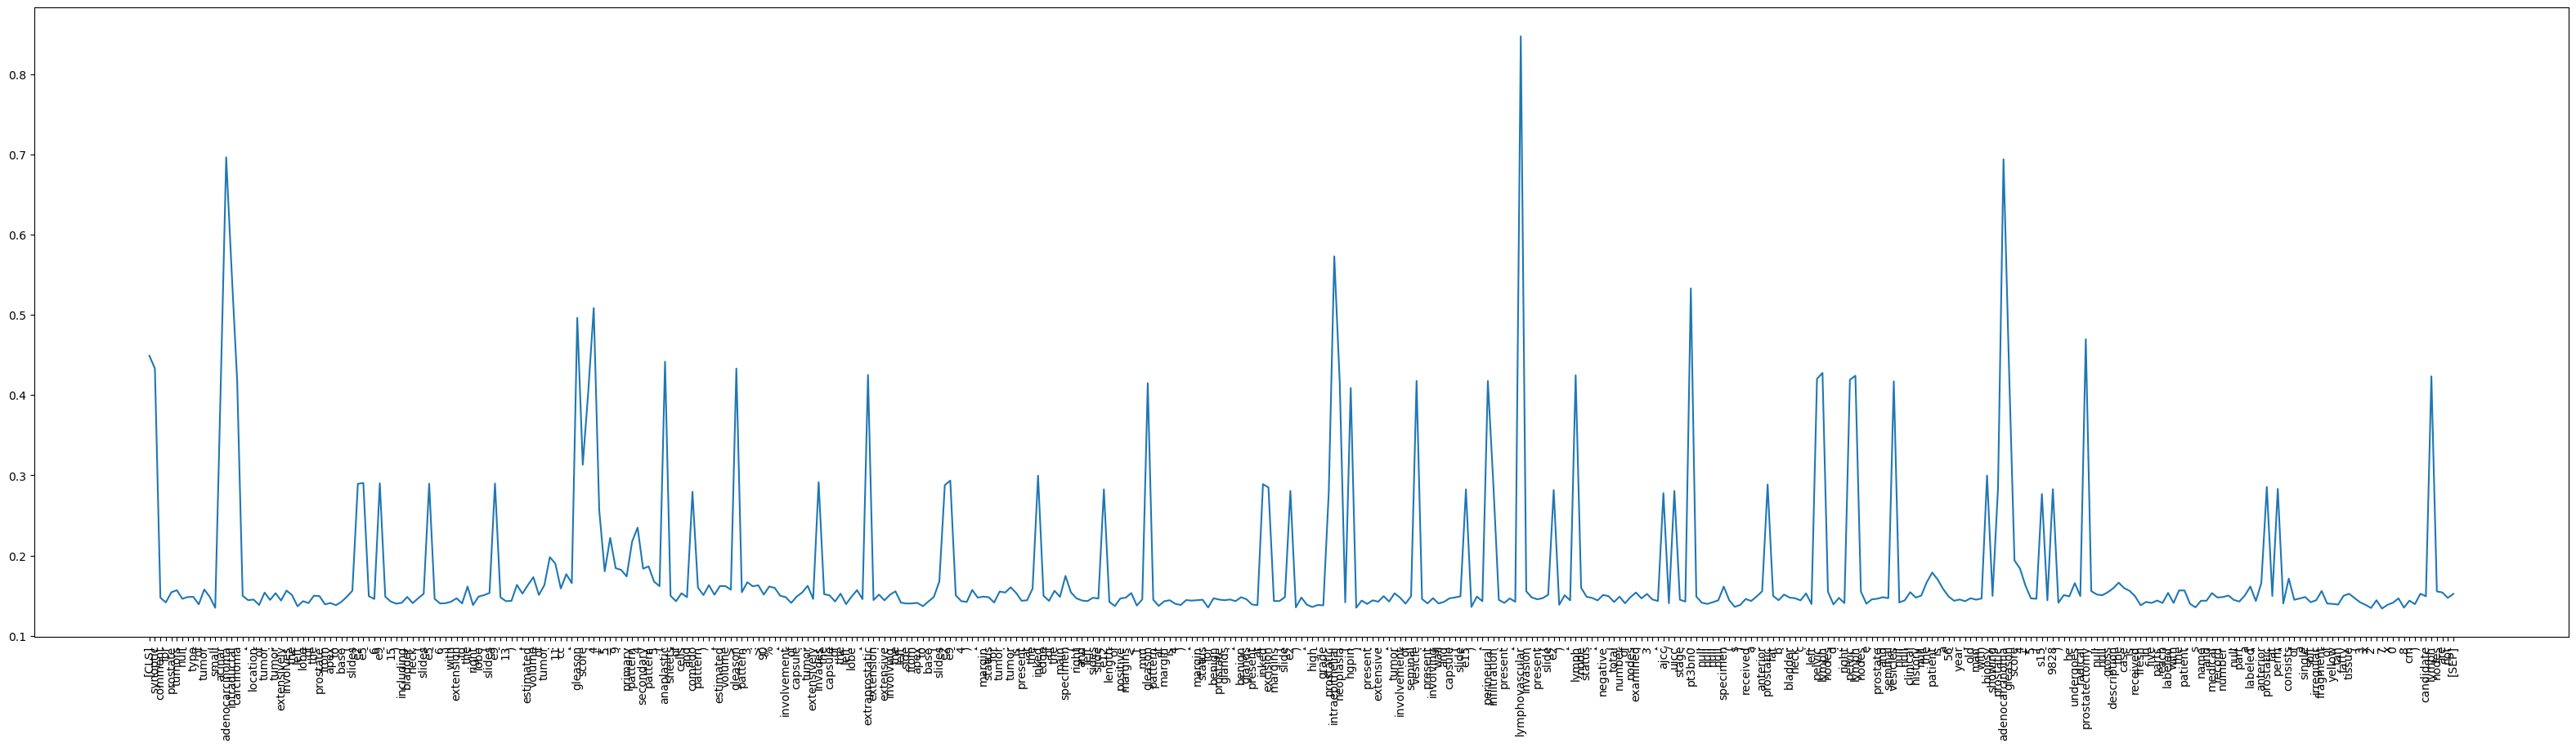

In [160]:
import matplotlib.pyplot as plt

toks = tokenizer.convert_ids_to_tokens([x for x in encoding['input_ids'][0] if x !=0 ])
intervals, words = compute_word_intervals(toks)

word_scores = combine_token_scores(intervals, scores)
irrel_word_scores = combine_token_scores(intervals, irrel_scores) # for ablation purpose

plt.figure(figsize=(40, 10))

x = range(len(words))
y = word_scores
my_xticks = words
plt.xticks(x, my_xticks, rotation=90)
plt.plot(x, y)

In [161]:
ind = np.argpartition(word_scores, -4)[-4:]
np.array(words)[ind]
#words[np.argmax(word_scores)]

array(['intraepithelial', 'adenocarcinoma', 'lymphovascular',
       'adenocarcinoma'], dtype='<U15')

In [162]:
import matplotlib
from IPython.core.display import display, HTML
from matplotlib.colors import LinearSegmentedColormap

def normalize_word_scores(word_scores):
    neg_pos_lst = [i for i, x in enumerate(word_scores) if x < 0]
    abs_word_scores = np.abs(word_scores)
    normalized = (abs_word_scores-min(abs_word_scores))/(max(abs_word_scores)-min(abs_word_scores)) # in [0, 1] range
    for i, x in enumerate(normalized):
        if i in neg_pos_lst:
            normalized[i] = -normalized[i]
    return normalized
            
def chop_cmap_frac(cmap: LinearSegmentedColormap, frac: float) -> LinearSegmentedColormap:
    """Chops off the ending 1- `frac` fraction of a colormap."""
    cmap_as_array = cmap(np.arange(256))
    cmap_as_array = cmap_as_array[:int(frac * len(cmap_as_array))]
    return LinearSegmentedColormap.from_list(cmap.name + f"_frac{frac}", cmap_as_array)

def colorize(words, color_array, mid=0, eps=1e-03):
    cmap_pos = LinearSegmentedColormap.from_list('', ['white', '#48b6df'])
    cmap_neg = LinearSegmentedColormap.from_list('', ['white', '#dd735b'])
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    for word, color in zip(words, color_array):
        if color > mid:
          color = matplotlib.colors.rgb2hex(cmap_pos(color)[:3])
        elif color < mid:
          color = matplotlib.colors.rgb2hex(cmap_neg(abs(color))[:3])
        colored_string += template.format(color, '&nbsp' + word + '&nbsp')
    return colored_string

In [163]:
normalized = normalize_word_scores(word_scores)
irrel_normalized = normalize_word_scores(irrel_word_scores)

In [164]:
s = colorize(words, normalized)
display(HTML(s))

In [165]:
s = colorize(words, irrel_normalized)
display(HTML(s))

In [166]:
s = colorize(words, normalized - irrel_normalized) # rel captures more importance on the primary Gleason sscore position and CLS (which is where the final prediction is made).
display(HTML(s))